# Download and Prepare MusicMIDI for COMMU Processing

In [1]:
!pip install boto3
!pip install python-dotenv
!pip install gensim==4.1.2
!pip install seaborn
!pip install openpyxl

In [2]:
import os
import boto3
import joblib
import shutil
import mido
import miditoolkit
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from pathlib import Path
from tqdm.notebook import tqdm

import dotenv
dotenv.load_dotenv()

sns.set()

In [3]:
# set some parameter
DATA_DIR = '../dataset'

In [4]:
# read in MIDI Metafiles
# parse chord progressions
# remove numbers from instruments
commu_meta = pd.read_csv(f"{DATA_DIR}/commu_meta.csv", index_col=0)
commu_meta['chord_progressions'] = commu_meta['chord_progressions'].apply(lambda x: literal_eval(x))
commu_meta['inst'] = commu_meta['inst'].apply(lambda x: re.sub(r'\d+', '', x))
commu_meta['inst'] = commu_meta['inst'].apply(lambda x: x.replace("__","").replace("-", ""))
commu_meta.head()


,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id
0,aminor,"[[Am, Am, Am, Am, Am, Am, Am, Am, C, C, C, C, ...",mid,8,120,cinematic,main_melody,string_ensemble,standard,4/4,101,102,train,commu00001
1,cmajor,"[[C, C, C, C, C, C, C, C, Dm, Dm, Dm, Dm, Dm, ...",mid_low,8,80,newage,accompaniment,acoustic_piano,standard,4/4,23,30,train,commu00002
2,aminor,"[[Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, ...",mid_high,8,150,cinematic,riff,string_violin,standard,4/4,123,127,train,commu00003
3,cmajor,"[[C, C, C, C, C, C, C, C, Gm, Gm, Gm, Gm, Gm, ...",mid,8,110,cinematic,pad,choir,standard,4/4,45,46,train,commu00004
4,aminor,"[[Am, Am, Am, Am, Em, Em, Em, Em, F, F, F, F, ...",mid_low,4,60,cinematic,pad,acoustic_piano,standard,4/4,21,22,train,commu00005


In [5]:
# clean some columns
# remove mid suffix
# list the chord progression
musicMIDI_meta = pd.read_csv(f"{DATA_DIR}/midi_metadata_file.csv")
musicMIDI_meta['id'] = musicMIDI_meta['file_name']
musicMIDI_meta['id'] = musicMIDI_meta['id'].apply(lambda x: x[:-4])
musicMIDI_meta['chord_progressions'] = musicMIDI_meta['chord_progression'].apply(lambda x: literal_eval(x))
musicMIDI_meta['audio_key'] = musicMIDI_meta['audio_key'].apply(lambda x: x.replace('-', ''))
musicMIDI_meta.drop(columns=['file_name', 'chord_progression'], inplace=True)
musicMIDI_meta.head()

,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions
0,Cmaj,unknown,10,192,electronic,unknown,Dulcimer,unknown,2/4,64,87,NaN,0004806f96307e317d116040af5b7861_11,"[Am, Am, Cmaj, Cmaj, Fmaj, Fmaj, Am, Am, Bmaj,..."
1,Fmaj,unknown,7,112,electronic,unknown,Brass Section,unknown,2/4,127,127,NaN,0004806f96307e317d116040af5b7861_12,"[F, F, F, F, A, A, A, A, C, C, G, G, F, F, F, ..."
2,Fmaj,unknown,12,163,electronic,unknown,Percussive Organ,unknown,2/4,31,85,NaN,0004806f96307e317d116040af5b7861_13,"[Dm, Dm, Dm, Dm, Fmaj, Fmaj, Fmaj, Fmaj, B, B,..."
3,Dm,unknown,19,109,electronic,unknown,SynthStrings 1,unknown,2/4,85,96,NaN,0004806f96307e317d116040af5b7861_2,"[Dm, Dm, Dm, Dm, Fmaj, Fmaj, Am, Am, Am, Am, G..."
4,Am,unknown,11,179,electronic,unknown,Lead 1 (square),unknown,2/4,27,113,NaN,0004806f96307e317d116040af5b7861_3,"[C, C, G, G, A, A, C, C, A, A, Gmaj, Gmaj, G, ..."


In [6]:
# fix chord progression label
def fix_chord_progression_label(chords):
    import re
    try:
        new_chord = []
        for c in chords:
            # replace number with empty string
            # c = re.sub(r'\d+', '', c)
            c = c.replace('-', '')
            c = c.replace('maj', '')
            new_chord.append(c)
        return [new_chord]
    except Exception as e:
        print(x)
        raise e

musicMIDI_meta['chord_progressions'] = musicMIDI_meta['chord_progressions'].apply(lambda x: fix_chord_progression_label(x))
musicMIDI_meta

,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions
0,Cmaj,unknown,10,192,electronic,unknown,Dulcimer,unknown,2/4,64,87,NaN,0004806f96307e317d116040af5b7861_11,"[[Am, Am, C, C, F, F, Am, Am, B, B, G, G, B, B..."
1,Fmaj,unknown,7,112,electronic,unknown,Brass Section,unknown,2/4,127,127,NaN,0004806f96307e317d116040af5b7861_12,"[[F, F, F, F, A, A, A, A, C, C, G, G, F, F, F,..."
2,Fmaj,unknown,12,163,electronic,unknown,Percussive Organ,unknown,2/4,31,85,NaN,0004806f96307e317d116040af5b7861_13,"[[Dm, Dm, Dm, Dm, F, F, F, F, B, B, G, G, Dm, ..."
3,Dm,unknown,19,109,electronic,unknown,SynthStrings 1,unknown,2/4,85,96,NaN,0004806f96307e317d116040af5b7861_2,"[[Dm, Dm, Dm, Dm, F, F, Am, Am, Am, Am, G, G, ..."
4,Am,unknown,11,179,electronic,unknown,Lead 1 (square),unknown,2/4,27,113,NaN,0004806f96307e317d116040af5b7861_3,"[[C, C, G, G, A, A, C, C, A, A, G, G, G, G, C,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62057,Cm,unknown,22,104,folk,unknown,Tango Accordion,unknown,4/4,70,95,NaN,fff824db4e363d902648ca4869a2b682_2,"[[C, C, C, C, E, E, E, E, C, C, C, C, C, C, C,..."
62058,Cm,unknown,15,130,folk,unknown,Tango Accordion,unknown,4/4,70,95,NaN,fff824db4e363d902648ca4869a2b682_3,"[[C, C, C, C, E, E, E, E, G, G, G, G, C, C, C,..."
62059,Fmaj,unknown,9,231,classical,unknown,Flute,unknown,4/4,79,90,NaN,fffdf64e3d6ff25c5b1a38b485f336c3_1,"[[C, C, C, C, F, F, F, F, C, C, C, C, F, F, F,..."
62060,Fmaj,unknown,10,193,classical,unknown,Piccolo,unknown,4/4,55,85,NaN,fffdf64e3d6ff25c5b1a38b485f336c3_2,"[[F, F, F, F, B, B, B, B, C, C, C, C, B, B, B,..."


In [7]:
# add key signature to MIDI files at the beginning of the file
def append_key_signature(input_path, output_path, midi_file_name, key):
    """
        Function to extract the minimum and maximum velocity from a given MIDI file
        Input: MIDI file path
        Output: Minimum velocity, Maximum velocity
    """
    from miditoolkit import MidiFile, KeySignature

    try:
        midi_file_path = input_path + '/' + midi_file_name + '.mid'
        # Load MIDI file and set up the key signature event
        midi_file = mido.MidiFile(midi_file_path)

        # Insert key signature event into the track
        position_ticks = 0 
        midi_file.tracks[0].append(mido.MetaMessage('key_signature', key=key, time=position_ticks))
        midi_file.tracks[0][-1], midi_file.tracks[0][-2] = midi_file.tracks[0][-2], midi_file.tracks[0][-1]
        # Save the MIDI file to the output path
        midi_file.save(f"{output_path}/{midi_file_name}.mid")

    except Exception as e:
        print(f"Error: {e}")
        return 
    return 

In [8]:
# input_path = f"{DATA_DIR}/processed_musicMIDI/raw"
# output_path = f"{DATA_DIR}/processed_musicMIDI/raw_updated"
# midi_file_name = '0004806f96307e317d116040af5b7861_11'
# append_key_signature(input_path, output_path, midi_file_name, 'F')

In [9]:
# # inser the key signature into all MIDI files
# input_path = f"{DATA_DIR}/processed_musicMIDI/raw"
# output_path = f"{DATA_DIR}/processed_musicMIDI/raw_updated"


# # create the folder if not exist
# Path(output_path).mkdir(parents=True, exist_ok=True)

# for i, row in tqdm(musicMIDI_meta.iterrows()):
#     midi_file_name = row["id"]
#     key_signature = row["audio_key"]

#     # remove hypens
#     # remove maj if maj exists in key signature
#     key_signature = key_signature.replace('-', '')
#     if 'maj' in key_signature:
#         key_signature = key_signature[:-3]
#     append_key_signature(input_path, output_path, midi_file_name, key_signature)

# Rename Columns to Match comMU

In [10]:
# musicMIDI_meta = musicMIDI_meta.rename(columns = {'key_signature': 'audio_key',
                                                #   'chord_progression': 'chord_progressions',
                                                #   'Max_Genre': 'genre',
                                                #   'instrument': 'inst',
                                                #   'mid': 'id'})

In [11]:
# # test for key signature changes
# midi_file_path = f'{DATA_DIR}/processed_musicMIDI/raw_updated/0004806f96307e317d116040af5b7861_11.mid'
# midi = miditoolkit.MidiFile(midi_file_path)
# midi_id = Path(midi_file_path).stem
# pitch_track_notes = [midi.instruments[0].notes]

# print(midi)

In [12]:
# # test for key signature changes
# midi_file_path = f'{DATA_DIR}/commu_midi/train/raw/commu00001.mid'
# midi = miditoolkit.MidiFile(midi_file_path)
# midi_id = Path(midi_file_path).stem
# pitch_track_notes = [midi.instruments[0].notes]

# print(midi)

# Extract min/max velocity

In [13]:
def extract_min_max_velocity(midi_file_path):
    """
        Function to extract the minimum and maximum velocity from a given MIDI file
        Input: MIDI file path
        Output: Minimum velocity, Maximum velocity
    """
    try:
        mid = mido.MidiFile(midi_file_path)

        velocity_data = []

        for track in mid.tracks:
            for msg in track:
                if msg.type == 'note_on':
                    velocity = msg.velocity
                    velocity_data.append(velocity)


        velocity_data = sorted(list(set(velocity_data)))
        velocity_data = velocity_data[1:]
        min_velocity = velocity_data[0]
        max_velocity = velocity_data[-1]

    except Exception as e:
        print(f"Error: {e}")
        return None, None

    return min_velocity, max_velocity


In [14]:
# determine when minor velocity is negative
musicMIDI_meta['neg_min_velocity'] = musicMIDI_meta.apply(lambda x: x['min_velocity'] < 0, axis=1)

# determine when max velocity is negative
musicMIDI_meta['neg_max_velocity'] = musicMIDI_meta.apply(lambda x: x['max_velocity'] < 0, axis=1)
musicMIDI_meta['neg_min_velocity'].value_counts(), musicMIDI_meta['neg_max_velocity'].value_counts()

(neg_min_velocity
 False    62062
 Name: count, dtype: int64,
 neg_max_velocity
 False    62062
 Name: count, dtype: int64)

In [15]:
# determine instances where the min/max velocidy is the same
musicMIDI_meta['min_max_velocity_same'] = musicMIDI_meta.apply(lambda x: x['min_velocity'] == x['max_velocity'], axis=1)
musicMIDI_meta['min_max_velocity_same'].value_counts()

min_max_velocity_same
False    40582
True     21480
Name: count, dtype: int64

In [16]:
# determine instances when min velocity is > max velocity
musicMIDI_meta['min_velocity_greater_than_max_velocity'] = musicMIDI_meta.apply(lambda x: x['min_velocity'] > x['max_velocity'], axis=1)
musicMIDI_meta['min_velocity_greater_than_max_velocity'].value_counts()

min_velocity_greater_than_max_velocity
False    62062
Name: count, dtype: int64

In [17]:
# drop all the min/max velocity columns
musicMIDI_meta.drop(columns=['neg_min_velocity', 'neg_max_velocity', 'min_max_velocity_same', 'min_velocity_greater_than_max_velocity'], inplace=True)

In [18]:
# # for MIDI files that have same min/max velocity, re-extract the min/max velocity 
# # check if the min/max velocity is the same
# # if it is, ignore the file
# # if it is not, update the min/max velocity record
# temp_data = []
# for i, row in tqdm(musicMIDI_meta.iterrows()):
#     if row['min_max_velocity_same']:
#         midi_file_path = f'{DATA_DIR}/processed_musicMIDI/raw/{row["id"]}.mid'
#         min_velocity, max_velocity = extract_min_max_velocity(midi_file_path)
        
#         if min_velocity != max_velocity:
#             temp_data.append([row['id'], min_velocity, max_velocity])


# temp_data[:5]

In [19]:
# # test print minmax velocity
# midi_file_path = f'{DATA_DIR}/musicMIDI/raw/014d0f3da9195dc1c9c23c2ad0e438f9_12.mid'
# # midi_file_path = f'{DATA_DIR}/commu_midi/train/raw/commu00003.mid'
# min_velocity, max_velocity = extract_min_max_velocity(midi_file_path)

# if min_velocity is not None and max_velocity is not None:
#     print(f"Minimum velocity: {min_velocity}")
#     print(f"Maximum velocity: {max_velocity}")
# else:
#     print("Failed to extract velocity information from the MIDI file.")

In [20]:
# # extract min/max velocity from all MIDI files
# velocity_data = []
# for i, row in tqdm(musicMIDI_meta.iterrows()):
#     print(row['id'])
#     midi_file_path = f'{DATA_DIR}/musicMIDI/raw/{row["id"]}.mid'
#     min_velocity, max_velocity = extract_min_max_velocity(midi_file_path)
#     velocity_data.append([row['id'], min_velocity, max_velocity])

# # get the missing data
# velocity_data = pd.DataFrame(velocity_data, columns=['id', 'min_velocity', 'max_velocity'])
# missing_midi = velocity_data[velocity_data['min_velocity'] != velocity_data['min_velocity']]
# missing_midi.to_csv(f'{DATA_DIR}/missing_metaMIDI.csv', index=False)

# # merge velocity data with musicMIDI_meta
# musicMIDI_meta = musicMIDI_meta.drop(columns=['file_name', 'min_velocity', 'max_velocity']).merge(velocity_data, on='id', how='left')
# musicMIDI_meta.head()

# Cleanup MetaMIDI dataset

In [21]:
# get all commu columns headers
# get all musicMIDI columns headers
commu_headers = commu_meta.columns.tolist()
musicMIDI_headers = musicMIDI_meta.columns.tolist()
commu_headers, musicMIDI_headers

(['audio_key',
  'chord_progressions',
  'pitch_range',
  'num_measures',
  'bpm',
  'genre',
  'track_role',
  'inst',
  'sample_rhythm',
  'time_signature',
  'min_velocity',
  'max_velocity',
  'split_data',
  'id'],
 ['audio_key',
  'pitch_range',
  'num_measures',
  'bpm',
  'genre',
  'track_roll',
  'inst',
  'sample_rhythm',
  'time_signature',
  'min_velocity',
  'max_velocity',
  'split_data',
  'id',
  'chord_progressions'])

In [22]:
# cleanup audio keys
musicMIDI_meta['audio_key'].unique()

# for key signature if ends with 'm' then it is minor
# else it is major
# replace "-" with empty string
# lower case the entire string
musicMIDI_meta['audio_key'] = musicMIDI_meta['audio_key'].apply(lambda x: x+'inor' if x.endswith('m') else x+'or')
musicMIDI_meta['audio_key'] = musicMIDI_meta['audio_key'].apply(lambda x: x.replace('-', ''))
musicMIDI_meta['audio_key'] = musicMIDI_meta['audio_key'].apply(lambda x: x.lower())
musicMIDI_meta['audio_key'].unique()

array(['cmajor', 'fmajor', 'dminor', 'aminor', 'eminor', 'dmajor',
       'gmajor', 'amajor', 'f#minor', 'bminor', 'bmajor', 'emajor',
       'gminor', 'fminor', 'c#major', 'f#major', 'c#minor', 'cminor',
       'g#minor'], dtype=object)

In [23]:
# get top 10 time signature
top_10 = musicMIDI_meta.groupby('time_signature').count().sort_values(by='id', ascending=False).head(10).index
musicMIDI_meta['time_signature'].unique(), top_10

(array(['2/4', '4/4', '3/4', '3/2', '1/4', '6/8', '2/2', '6/4', '9/8',
        '4/2', '12/8', '1/16', '8/4', '3/8', '5/4', '1/8', '5/8', '7/8',
        '3/16', '1/1', '7/4', '12/16', '31/1', '4/8', '10/8', '3/1',
        '13/8', '9/16', '32/8', '32/4', '8/8', '6/16', '5/16', '4/16',
        '11/16', '11/8', '16/4', '1/2', '4/1', '2/16'], dtype=object),
 Index(['4/4', '3/4', '2/4', '6/8', '1/4', '2/2', '6/4', '12/8', '3/8', '5/4'], dtype='object', name='time_signature'))

In [24]:
# get only top 10 time signatures
musicMIDI_meta = musicMIDI_meta[musicMIDI_meta['time_signature'].isin(top_10)]
musicMIDI_meta.head()

,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions
0,cmajor,unknown,10,192,electronic,unknown,Dulcimer,unknown,2/4,64,87,NaN,0004806f96307e317d116040af5b7861_11,"[[Am, Am, C, C, F, F, Am, Am, B, B, G, G, B, B..."
1,fmajor,unknown,7,112,electronic,unknown,Brass Section,unknown,2/4,127,127,NaN,0004806f96307e317d116040af5b7861_12,"[[F, F, F, F, A, A, A, A, C, C, G, G, F, F, F,..."
2,fmajor,unknown,12,163,electronic,unknown,Percussive Organ,unknown,2/4,31,85,NaN,0004806f96307e317d116040af5b7861_13,"[[Dm, Dm, Dm, Dm, F, F, F, F, B, B, G, G, Dm, ..."
3,dminor,unknown,19,109,electronic,unknown,SynthStrings 1,unknown,2/4,85,96,NaN,0004806f96307e317d116040af5b7861_2,"[[Dm, Dm, Dm, Dm, F, F, Am, Am, Am, Am, G, G, ..."
4,aminor,unknown,11,179,electronic,unknown,Lead 1 (square),unknown,2/4,27,113,NaN,0004806f96307e317d116040af5b7861_3,"[[C, C, G, G, A, A, C, C, A, A, G, G, G, G, C,..."


In [25]:
# add missing headers to musicMIDI_meta
for header in commu_headers:
    if header not in musicMIDI_headers:
        musicMIDI_meta[header] = 'unknown'


# fill the rese with unknown
musicMIDI_meta.fillna('unknown', inplace=True)

C:\Users\ktrin\AppData\Local\Temp\ipykernel_20424\757961987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musicMIDI_meta[header] = 'unknown'
C:\Users\ktrin\AppData\Local\Temp\ipykernel_20424\757961987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musicMIDI_meta.fillna('unknown', inplace=True)


In [26]:
def parse_inst(inst):
    """
        Function to cleanup the instrument column
    """
    try:
        # remove the number from the instrument
        # replace extra characters with empty string
        # replace last underscore with empty string
        inst = re.sub(r'\d+', '', inst)
        inst = inst.lower().replace('(', '').replace(')', '').replace('-', '').replace(' ', '_').replace("__", "_")
        if inst.endswith('_'):
            inst = inst[:-1]
        return inst
    except:
        return 'unknown'

In [27]:
# parse instrument
musicMIDI_meta['inst'] = musicMIDI_meta['inst'].apply(lambda x: parse_inst(x))

# fill unknown instrument with ensemble
musicMIDI_meta['inst'] = musicMIDI_meta['inst'].apply(lambda x: 'ensemble' if x == 'unknown' else x)
musicMIDI_meta

C:\Users\ktrin\AppData\Local\Temp\ipykernel_20424\95340619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musicMIDI_meta['inst'] = musicMIDI_meta['inst'].apply(lambda x: parse_inst(x))
C:\Users\ktrin\AppData\Local\Temp\ipykernel_20424\95340619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musicMIDI_meta['inst'] = musicMIDI_meta['inst'].apply(lambda x: 'ensemble' if x == 'unknown' else x)


,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions,track_role
0,cmajor,unknown,10,192,electronic,unknown,dulcimer,unknown,2/4,64,87,unknown,0004806f96307e317d116040af5b7861_11,"[[Am, Am, C, C, F, F, Am, Am, B, B, G, G, B, B...",unknown
1,fmajor,unknown,7,112,electronic,unknown,brass_section,unknown,2/4,127,127,unknown,0004806f96307e317d116040af5b7861_12,"[[F, F, F, F, A, A, A, A, C, C, G, G, F, F, F,...",unknown
2,fmajor,unknown,12,163,electronic,unknown,percussive_organ,unknown,2/4,31,85,unknown,0004806f96307e317d116040af5b7861_13,"[[Dm, Dm, Dm, Dm, F, F, F, F, B, B, G, G, Dm, ...",unknown
3,dminor,unknown,19,109,electronic,unknown,synthstrings,unknown,2/4,85,96,unknown,0004806f96307e317d116040af5b7861_2,"[[Dm, Dm, Dm, Dm, F, F, Am, Am, Am, Am, G, G, ...",unknown
4,aminor,unknown,11,179,electronic,unknown,lead_square,unknown,2/4,27,113,unknown,0004806f96307e317d116040af5b7861_3,"[[C, C, G, G, A, A, C, C, A, A, G, G, G, G, C,...",unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62057,cminor,unknown,22,104,folk,unknown,tango_accordion,unknown,4/4,70,95,unknown,fff824db4e363d902648ca4869a2b682_2,"[[C, C, C, C, E, E, E, E, C, C, C, C, C, C, C,...",unknown
62058,cminor,unknown,15,130,folk,unknown,tango_accordion,unknown,4/4,70,95,unknown,fff824db4e363d902648ca4869a2b682_3,"[[C, C, C, C, E, E, E, E, G, G, G, G, C, C, C,...",unknown
62059,fmajor,unknown,9,231,classical,unknown,flute,unknown,4/4,79,90,unknown,fffdf64e3d6ff25c5b1a38b485f336c3_1,"[[C, C, C, C, F, F, F, F, C, C, C, C, F, F, F,...",unknown
62060,fmajor,unknown,10,193,classical,unknown,piccolo,unknown,4/4,55,85,unknown,fffdf64e3d6ff25c5b1a38b485f336c3_2,"[[F, F, F, F, B, B, B, B, C, C, C, C, B, B, B,...",unknown


In [28]:
def parse_genre(genre):
    """
        Function to cleanup the instrument column
    """
    try:
        return genre.lower().replace(' ', '').replace(',', ' ').replace('/', ' ').replace('&', ' ').replace('-', ' ').replace(' ', '_').replace("__", "_")
    
    except:
        return 'unknown'

# parse genre
# treat special case of folk_world__country
musicMIDI_meta['genre'] = musicMIDI_meta['genre'].apply(lambda x: parse_genre(x))
musicMIDI_meta.head()

C:\Users\ktrin\AppData\Local\Temp\ipykernel_20424\147891459.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musicMIDI_meta['genre'] = musicMIDI_meta['genre'].apply(lambda x: parse_genre(x))


,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions,track_role
0,cmajor,unknown,10,192,electronic,unknown,dulcimer,unknown,2/4,64,87,unknown,0004806f96307e317d116040af5b7861_11,"[[Am, Am, C, C, F, F, Am, Am, B, B, G, G, B, B...",unknown
1,fmajor,unknown,7,112,electronic,unknown,brass_section,unknown,2/4,127,127,unknown,0004806f96307e317d116040af5b7861_12,"[[F, F, F, F, A, A, A, A, C, C, G, G, F, F, F,...",unknown
2,fmajor,unknown,12,163,electronic,unknown,percussive_organ,unknown,2/4,31,85,unknown,0004806f96307e317d116040af5b7861_13,"[[Dm, Dm, Dm, Dm, F, F, F, F, B, B, G, G, Dm, ...",unknown
3,dminor,unknown,19,109,electronic,unknown,synthstrings,unknown,2/4,85,96,unknown,0004806f96307e317d116040af5b7861_2,"[[Dm, Dm, Dm, Dm, F, F, Am, Am, Am, Am, G, G, ...",unknown
4,aminor,unknown,11,179,electronic,unknown,lead_square,unknown,2/4,27,113,unknown,0004806f96307e317d116040af5b7861_3,"[[C, C, G, G, A, A, C, C, A, A, G, G, G, G, C,...",unknown


In [29]:
# randomize 10% of the dataset for validation
musicMIDI_meta_val = musicMIDI_meta.sample(frac=.10, random_state=3463)

# remove validation data from training data
musicMIDI_meta = musicMIDI_meta.drop(musicMIDI_meta_val.index)

# label the split data column with train and val
musicMIDI_meta['split_data'] = 'train'
musicMIDI_meta_val['split_data'] = 'val'

# combine the data
musicMIDI_meta = pd.concat([musicMIDI_meta, musicMIDI_meta_val])
musicMIDI_meta = musicMIDI_meta.reset_index(drop=True)
musicMIDI_meta.head()

,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions,track_role
0,cmajor,unknown,10,192,electronic,unknown,dulcimer,unknown,2/4,64,87,train,0004806f96307e317d116040af5b7861_11,"[[Am, Am, C, C, F, F, Am, Am, B, B, G, G, B, B...",unknown
1,fmajor,unknown,7,112,electronic,unknown,brass_section,unknown,2/4,127,127,train,0004806f96307e317d116040af5b7861_12,"[[F, F, F, F, A, A, A, A, C, C, G, G, F, F, F,...",unknown
2,fmajor,unknown,12,163,electronic,unknown,percussive_organ,unknown,2/4,31,85,train,0004806f96307e317d116040af5b7861_13,"[[Dm, Dm, Dm, Dm, F, F, F, F, B, B, G, G, Dm, ...",unknown
3,aminor,unknown,11,179,electronic,unknown,lead_square,unknown,2/4,27,113,train,0004806f96307e317d116040af5b7861_3,"[[C, C, G, G, A, A, C, C, A, A, G, G, G, G, C,...",unknown
4,dminor,unknown,7,112,electronic,unknown,lead_square,unknown,2/4,126,126,train,0004806f96307e317d116040af5b7861_5,"[[D, D, D, D, F, F, A, A, A, A, G, G, D, D, D,...",unknown


In [30]:
# move the files to the correct folder
# move the data to the respective folder
full_data_dir = f"{DATA_DIR}/processed_musicMIDI/raw_updated"
train_dir = f"{DATA_DIR}/meta_midi/train/raw"
val_dir = f"{DATA_DIR}/meta_midi/val/raw"

# create the folder if not exist
# check if the folder exist:
# if not create the folder
# else do nothing
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)


# copy the data using the split_data column
for i, row in tqdm(musicMIDI_meta.iterrows()):
    try:
        # copy the file and replace underscore with hyphen
        # also replace the id with same structure
        if row['split_data'] == 'train':
            shutil.copy(f"{full_data_dir}/{row['id']}.mid", f"{train_dir}/{row['id'].replace('_', '-')}.mid")
            musicMIDI_meta.loc[i, 'id'] = row['id'].replace('_', '-')
        elif row['split_data'] == 'val':
            shutil.copy(f"{full_data_dir}/{row['id']}.mid", f"{val_dir}/{row['id'].replace('_', '-')}.mid")
            musicMIDI_meta.loc[i, 'id'] = row['id'].replace('_', '-')
    except Exception as e:
        print(e)
        pass

0it [00:00, ?it/s]

In [31]:
musicMIDI_meta.to_csv(f"{DATA_DIR}/midi_metadata_file_cleaned.csv", index=False)

In [32]:
# append the commu dataframe and 
master_midi = pd.concat([commu_meta, musicMIDI_meta], axis=0)
# create a new feature with unique chord/note
master_midi['unique_chord_n_note'] = master_midi['chord_progressions'].apply(lambda x: list(set(x[0])))
master_midi.head()

,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,track_roll,unique_chord_n_note
0,aminor,"[[Am, Am, Am, Am, Am, Am, Am, Am, C, C, C, C, ...",mid,8,120,cinematic,main_melody,string_ensemble,standard,4/4,101,102,train,commu00001,NaN,"[Am, G, Dm, C, D]"
1,cmajor,"[[C, C, C, C, C, C, C, C, Dm, Dm, Dm, Dm, Dm, ...",mid_low,8,80,newage,accompaniment,acoustic_piano,standard,4/4,23,30,train,commu00002,NaN,"[Am, Dm, G, C, G7, F]"
2,aminor,"[[Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, ...",mid_high,8,150,cinematic,riff,string_violin,standard,4/4,123,127,train,commu00003,NaN,"[F, E+, E, Am]"
3,cmajor,"[[C, C, C, C, C, C, C, C, Gm, Gm, Gm, Gm, Gm, ...",mid,8,110,cinematic,pad,choir,standard,4/4,45,46,train,commu00004,NaN,"[A#, Dm, G, C, F, Gm]"
4,aminor,"[[Am, Am, Am, Am, Em, Em, Em, Em, F, F, F, F, ...",mid_low,4,60,cinematic,pad,acoustic_piano,standard,4/4,21,22,train,commu00005,NaN,"[Em, F, Am]"


In [33]:
master_midi.to_csv(f"{DATA_DIR}/master_midi_meta.csv", index=False)

In [34]:
isnt_df = musicMIDI_meta.groupby('inst').count().sort_values(by='id', ascending=False)
genre_df = musicMIDI_meta.groupby('genre').count().sort_values(by='id', ascending=False)

In [35]:
isnt_df

,audio_key,pitch_range,num_measures,bpm,genre,track_roll,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions,track_role
inst,,,,,,,,,,,,,,
ensemble,4697,4697,4697,4697,4697,4697,4697,4697,4697,4697,4697,4697,4697,4697
overdriven_guitar,3982,3982,3982,3982,3982,3982,3982,3982,3982,3982,3982,3982,3982,3982
acoustic_bass,3393,3393,3393,3393,3393,3393,3393,3393,3393,3393,3393,3393,3393,3393
acoustic_guitar_nylon,3230,3230,3230,3230,3230,3230,3230,3230,3230,3230,3230,3230,3230,3230
electric_guitar_muted,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
helicopter,20,20,20,20,20,20,20,20,20,20,20,20,20,20
telephone_ring,16,16,16,16,16,16,16,16,16,16,16,16,16,16
tinkle_bell,15,15,15,15,15,15,15,15,15,15,15,15,15,15


In [36]:
genre_df

,audio_key,pitch_range,num_measures,bpm,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions,track_role
genre,,,,,,,,,,,,,,
rock,19972,19972,19972,19972,19972,19972,19972,19972,19972,19972,19972,19972,19972,19972
pop,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929
metal,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908
classical,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416
electronic,3345,3345,3345,3345,3345,3345,3345,3345,3345,3345,3345,3345,3345,3345
dance,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656
country,2602,2602,2602,2602,2602,2602,2602,2602,2602,2602,2602,2602,2602,2602
soul,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955
oldie,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620


<Figure size 640x480 with 0 Axes>

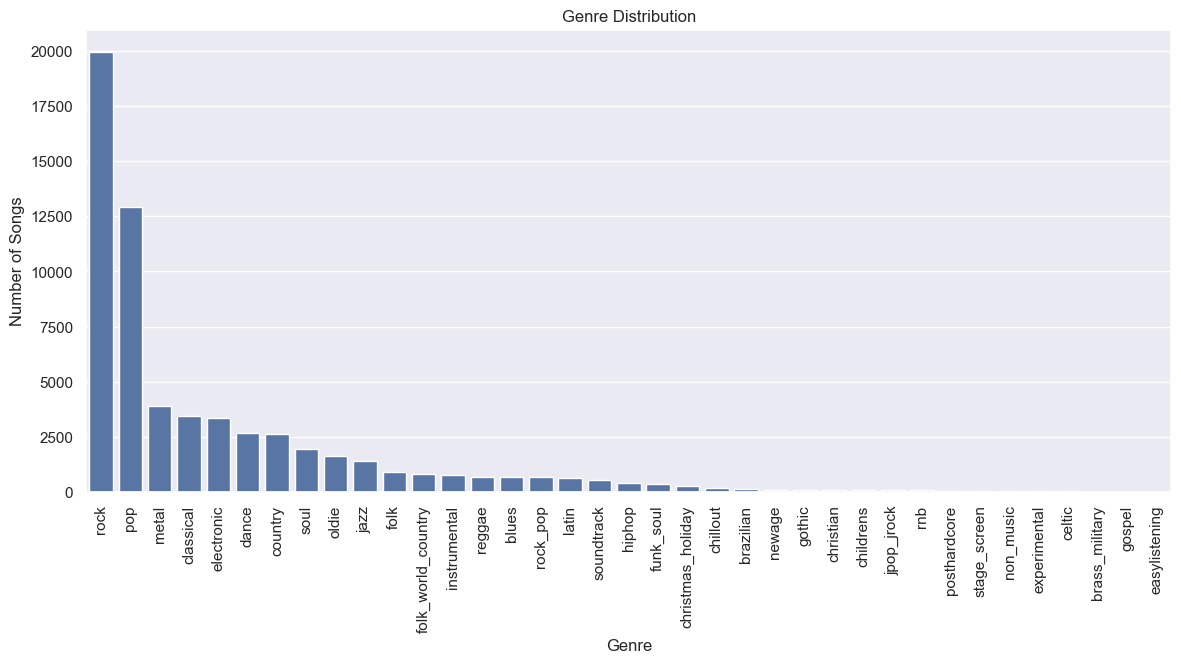

In [39]:
# plot inverted bar chart
plt.clf()
plt.figure(figsize=(14,6))
sns.barplot(x=genre_df.index, y=genre_df['id'])
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
#plt.savefig(f"{DATA_DIR}/genre_dist.png", bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

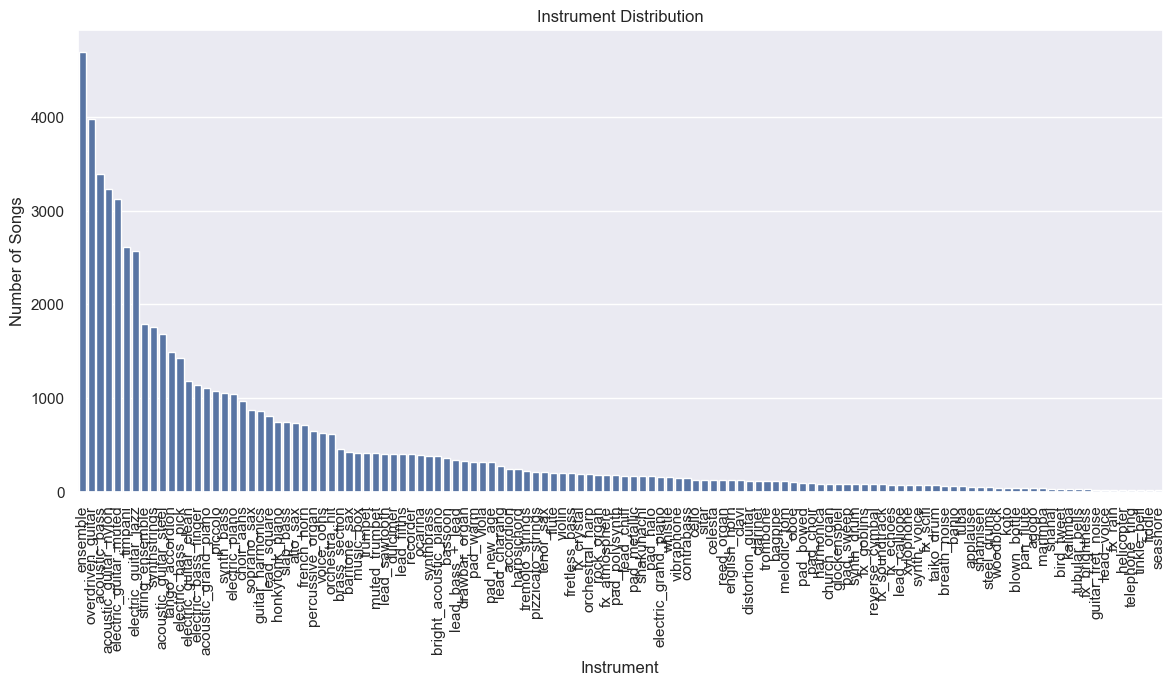

In [38]:
# plot inverted bar chart
plt.clf()
plt.figure(figsize=(14,6))
sns.barplot(x=isnt_df.index, y=isnt_df['id'])
plt.title('Instrument Distribution')
plt.xlabel('Instrument')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
#plt.savefig(f"{DATA_DIR}/genre_dist.png", bbox_inches='tight')
plt.show()

In [40]:
# number of unique instruments
len(musicMIDI_meta.groupby('inst').count().index)

122

# Applying Cosine Similarity to Group Instruments

In [41]:
import gensim.downloader

# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [42]:
# get the word2vec model
embed_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [43]:
#Current Instrument Map
INST_MAP = {
    "accordion": 1,
    "acoustic_bass": 3,
    "acoustic_guitar": 3,
    "acoustic_piano": 0,
    "banjo": 3,
    "bassoon": 5,
    "bell": 2,
    "brass_ensemble": 5,
    "celesta": 2,
    "choir": 7,
    "clarinet": 5,
    "drums_full": 6,
    "drums_tops": 6,
    "electric_bass": 3,
    "electric_guitar_clean": 3,
    "electric_guitar_distortion": 3,
    "electric_piano": 0,
    "fiddle": 4,
    "flute": 5,
    "glockenspiel": 2,
    "harp": 3,
    "harpsichord": 0,
    "horn": 5,
    "keyboard": 0,
    "mandolin": 3,
    "marimba": 2,
    "nylon_guitar": 3,
    "oboe": 5,
    "organ": 0,
    "oud": 3,
    "pad_synth": 4,
    "percussion": 6,
    "recorder": 5,
    "sitar": 3,
    "string_cello": 4,
    "string_double_bass": 4,
    "string_ensemble": 4,
    "string_viola": 4,
    "string_violin": 4,
    "synth_bass": 3,
    "synth_bass_808": 3,
    "synth_bass_wobble": 3,
    "synth_bell": 2,
    "synth_lead": 1,
    "synth_pad": 4,
    "synth_pluck": 7,
    "synth_voice": 7,
    "timpani": 6,
    "trombone": 5,
    "trumpet": 5,
    "tuba": 5,
    "ukulele": 3,
    "vibraphone": 2,
    "whistle": 7,
    "xylophone": 2,
    "zither": 3,
    "orgel": 2,
    "synth_brass": 5,
    "sax": 5,
    "bamboo_flute": 5,
    "yanggeum": 3,
    "vocal": 8,
}
len(INST_MAP.keys())

62

In [44]:
# inverted index of the instrument map
# make the value the list of all instrument with the same numerical value
INV_INST_MAP = {}
for k, v in INST_MAP.items():
    if v not in INV_INST_MAP:
        INV_INST_MAP[v] = [k]
    else:
        INV_INST_MAP[v].append(k)

# get all keys 
current_inst = list(INST_MAP.keys())
current_inst.sort()
current_inst[:5]

['accordion',
 'acoustic_bass',
 'acoustic_guitar',
 'acoustic_piano',
 'bamboo_flute']

In [45]:
# for each key in the current instrument map, split by underscore
splitted_inst = [inst.split('_') for inst in current_inst]

# for each splitted instrument, get the word2vec embedding
# if more than 1 word, get the sum of the embedding
# else get the embedding of the word
# store the embedding in a dictionary
inst_embedding = {}
for inst in splitted_inst:
    try:

        if len(inst) > 1:
            inst_embedding['_'.join(inst)] = np.sum([embed_vectors[word] for word in inst], axis=0)
        else:
            inst_embedding[inst[0]] = embed_vectors[inst[0]]
    except Exception as e:
        print(inst, e)
        pass

inst_embedding

['yanggeum'] "Key 'yanggeum' not present"


{'accordion': array([ 5.4066e-02,  6.4252e-01, -1.6742e-01, -3.0200e-01,  4.1525e-02,
         6.5271e-02, -1.7492e-02, -3.2842e-01, -1.1292e-01,  9.7258e-01,
        -3.6843e-01,  5.8830e-01,  4.3790e-01,  4.3049e-01,  1.9019e-01,
        -2.9418e-01,  5.7479e-02, -3.4804e-01,  5.1317e-01,  2.9595e-01,
         4.7305e-01,  4.6508e-01, -7.7993e-01,  2.3653e-02, -5.8600e-01,
         1.4179e-01,  3.0554e-01,  1.2656e-01, -3.0937e-01,  9.7156e-02,
        -6.4710e-01,  7.1918e-02,  3.6683e-02, -2.1380e-01,  1.2762e-02,
         2.9374e-01,  3.5986e-01, -3.7299e-01,  9.1427e-02,  9.1734e-01,
         1.8356e-01, -3.0644e-01,  3.4115e-01, -1.3775e-01,  2.0112e-01,
         4.8406e-01,  9.1369e-01, -1.3351e-01, -7.6706e-02,  2.6111e-01,
         5.8429e-01,  5.3471e-01,  1.4150e-01, -1.7875e-01,  3.6040e-02,
        -3.9326e-01,  3.9136e-01, -3.1937e-01,  5.0539e-01, -1.5030e-01,
         6.2491e-01,  6.2137e-02,  1.3244e-01,  7.4171e-02, -1.9415e-01,
         2.7015e-01,  4.4510e-01,  4.8

In [46]:
# get all available instruments in musicMIDI
# lower case all the instruments
# drop illegal instruments
musicMIDI_meta = musicMIDI_meta[~(musicMIDI_meta['inst'] != musicMIDI_meta['inst'])]
new_instuments = musicMIDI_meta['inst'].unique().tolist()

# remove parenthesis and hyphen
# replace space with underscore
new_instuments.sort()

# for each key in the current instrument map, split by underscore
new_splitted_inst = [inst.split('_') for inst in new_instuments]
new_splitted_inst[:5]

[['accordion'],
 ['acoustic', 'bass'],
 ['acoustic', 'grand', 'piano'],
 ['acoustic', 'guitar', 'nylon'],
 ['acoustic', 'guitar', 'steel']]

In [47]:
# for each splitted instrument, get the word2vec embedding
# if more than 1 word, get the sum of the embedding
# else get the embedding of the word
# store the embedding in a dictionary
new_inst_embedding = {}
for inst in new_splitted_inst:
    try:
        if len(inst) > 1:
            new_inst_embedding['_'.join(inst)] = np.sum([embed_vectors[word] for word in inst], axis=0)
        else:
            new_inst_embedding[inst[0]] = embed_vectors[inst[0]]
    except Exception as e:
        print(inst, e)
        pass

new_inst_embedding

['clavi'] "Key 'clavi' not present"
['lead', 'charang'] "Key 'charang' not present"
['lead', 'chiff'] "Key 'chiff' not present"
['pad', 'polysynth'] "Key 'polysynth' not present"
['shanai'] "Key 'shanai' not present"
['synthbrass'] "Key 'synthbrass' not present"
['synthstrings'] "Key 'synthstrings' not present"


{'accordion': array([ 5.4066e-02,  6.4252e-01, -1.6742e-01, -3.0200e-01,  4.1525e-02,
         6.5271e-02, -1.7492e-02, -3.2842e-01, -1.1292e-01,  9.7258e-01,
        -3.6843e-01,  5.8830e-01,  4.3790e-01,  4.3049e-01,  1.9019e-01,
        -2.9418e-01,  5.7479e-02, -3.4804e-01,  5.1317e-01,  2.9595e-01,
         4.7305e-01,  4.6508e-01, -7.7993e-01,  2.3653e-02, -5.8600e-01,
         1.4179e-01,  3.0554e-01,  1.2656e-01, -3.0937e-01,  9.7156e-02,
        -6.4710e-01,  7.1918e-02,  3.6683e-02, -2.1380e-01,  1.2762e-02,
         2.9374e-01,  3.5986e-01, -3.7299e-01,  9.1427e-02,  9.1734e-01,
         1.8356e-01, -3.0644e-01,  3.4115e-01, -1.3775e-01,  2.0112e-01,
         4.8406e-01,  9.1369e-01, -1.3351e-01, -7.6706e-02,  2.6111e-01,
         5.8429e-01,  5.3471e-01,  1.4150e-01, -1.7875e-01,  3.6040e-02,
        -3.9326e-01,  3.9136e-01, -3.1937e-01,  5.0539e-01, -1.5030e-01,
         6.2491e-01,  6.2137e-02,  1.3244e-01,  7.4171e-02, -1.9415e-01,
         2.7015e-01,  4.4510e-01,  4.8

In [48]:
# compute a list of all possible permutations
import itertools

# for each instrument between the new and old instrument map
# compute the cosine similarity
pair_wise_similarity = []
for inst_1, inst_2 in itertools.product(inst_embedding.keys(), new_inst_embedding.keys()):
    # if inst_1 == inst_2:
        # continue
    cosine = np.dot(inst_embedding[inst_1], new_inst_embedding[inst_2])/(np.linalg.norm(inst_embedding[inst_1])*np.linalg.norm(new_inst_embedding[inst_2]))
    pair_wise_similarity.append([inst_2, inst_1, cosine])

# aggregate the cosine similarity into a dataframe
pair_wise_similarity_df = pd.DataFrame(pair_wise_similarity, columns=['new_isnt', 'current_inst', 'cosine_similarity'])

best_similarity = []
# for each new instrument, get the instrument with the highest cosine similarity
for new_inst, similarity_df in pair_wise_similarity_df.groupby('new_isnt'):
    best_similarity.append(similarity_df.sort_values('cosine_similarity', ascending=False).iloc[0].tolist())

best_similarity_df = pd.DataFrame(best_similarity, columns=['new_isnt', 'current_inst', 'cosine_similarity'])
best_similarity_df['inst_map'] = best_similarity_df['current_inst'].apply(lambda x: INST_MAP[x])
best_similarity_df

,new_isnt,current_inst,cosine_similarity,inst_map
0,accordion,accordion,1.000000,1
1,acoustic_bass,acoustic_bass,1.000000,3
2,acoustic_grand_piano,acoustic_piano,0.875669,0
3,acoustic_guitar_nylon,nylon_guitar,0.929281,3
4,acoustic_guitar_steel,acoustic_guitar,0.898544,3
...,...,...,...,...
110,violin,string_violin,0.852045,4
111,voice_oohs,synth_voice,0.581818,7
112,whistle,whistle,1.000000,7
113,woodblock,harpsichord,0.264353,0


In [49]:
# for instrument that are not in the current instrument map,
# manually assesst the similarity and fill the instrument map accordingly 
inst_not_available = []
for inst in musicMIDI_meta['inst'].unique():
    if inst not in best_similarity_df['new_isnt'].unique():
        inst_not_available.append(inst)
inst_not_available

['pad_polysynth',
 'synthstrings',
 'synthbrass',
 'clavi',
 'lead_chiff',
 'lead_charang',
 'shanai']

In [50]:
non_similarity_mapping = { 
    "synthbrass": 5,
    "synthstrings": 4,
    "shanai": 5,
    "clavi": 1,
    "pad_polysynth": 1,
    "lead_charang": 3,
    "lead_chiff": 0
}

NEW_INST_MAP = best_similarity_df[['new_isnt', 'inst_map']].set_index('new_isnt').to_dict()
NEW_INST_MAP=NEW_INST_MAP['inst_map']
NEW_INST_MAP.update(non_similarity_mapping)
NEW_INST_MAP

{'accordion': 1,
 'acoustic_bass': 3,
 'acoustic_grand_piano': 0,
 'acoustic_guitar_nylon': 3,
 'acoustic_guitar_steel': 3,
 'agogo': 2,
 'alto_sax': 5,
 'applause': 8,
 'bagpipe': 1,
 'banjo': 3,
 'baritone_sax': 5,
 'bassoon': 5,
 'bird_tweet': 2,
 'blown_bottle': 7,
 'brass_section': 5,
 'breath_noise': 3,
 'bright_acoustic_piano': 0,
 'celesta': 2,
 'cello': 4,
 'choir_aahs': 7,
 'church_organ': 0,
 'clarinet': 5,
 'contrabass': 5,
 'distortion_guitar': 3,
 'drawbar_organ': 0,
 'dulcimer': 3,
 'electric_bass_finger': 3,
 'electric_bass_pick': 3,
 'electric_grand_piano': 0,
 'electric_guitar_clean': 3,
 'electric_guitar_jazz': 0,
 'electric_guitar_muted': 3,
 'electric_piano': 0,
 'english_horn': 5,
 'ensemble': 5,
 'fiddle': 4,
 'flute': 5,
 'french_horn': 5,
 'fretless_bass': 3,
 'fx_atmosphere': 3,
 'fx_brightness': 7,
 'fx_crystal': 5,
 'fx_echoes': 7,
 'fx_goblins': 7,
 'fx_rain': 1,
 'fx_scifi': 7,
 'fx_soundtrack': 3,
 'glockenspiel': 2,
 'guitar_fret_noise': 3,
 'guitar_harm

In [51]:
# # MAP all keys with synth to synnthetic group 1 using regex
# synth_group = {k: v for k, v in NEW_INST_MAP.items() if not k.find('synth')}
# synth_group

In [52]:
# define updated instrument grouping
INST_GROUP = {
    0: 'keyboard',
    1: 'accordian',
    2: 'bell',
    3: 'guitar',
    4: 'string',
    5: 'brass',
    6: 'percussion',
    7: 'choir',
    8: 'vocal',
    9: 'ensemble'
}

In [53]:
# replace ensemble with a new category
# update the original inst map
NEW_INST_MAP['ensemble'] = 9
INST_MAP.update(NEW_INST_MAP)
print(len(INST_MAP.keys()))

158


In [53]:
# check to see if all instruments are mapped
# inverted index of the instrument map
# make the value the list of all instrument with the same numerical value
INV_INST_MAP = {}
for k, v in INST_MAP.items():
    if v not in INV_INST_MAP:
        INV_INST_MAP[v] = [k]
    else:
        INV_INST_MAP[v].append(k)

# get all keys 
INV_INST_MAP[8]

['vocal', 'applause']

In [54]:
# map the new dictionary to the musicMIDI_meta dataframe
master_midi['inst_mapping'] = master_midi['inst'].map(INST_MAP)
master_midi['updated_inst'] = master_midi['inst_mapping'].map(INST_GROUP)
master_midi[(master_midi['inst_mapping'] != master_midi['inst_mapping'])]


musicMIDI_meta['inst_mapping'] = musicMIDI_meta['inst'].map(INST_MAP)
musicMIDI_meta['updated_inst'] = musicMIDI_meta['inst_mapping'].map(INST_GROUP)
musicMIDI_meta[(musicMIDI_meta['inst_mapping'] != musicMIDI_meta['inst_mapping'])]


,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions,track_role,inst_mapping,updated_inst


In [55]:
# map the new dictionary to the musicMIDI_meta dataframe
master_midi['inst_mapping'] = master_midi['inst'].map(INST_MAP)
master_midi['updated_inst'] = master_midi['inst_mapping'].map(INST_GROUP)
master_midi = master_midi[~(master_midi['inst_mapping'] != master_midi['inst_mapping'])]


musicMIDI_meta['inst_mapping'] = musicMIDI_meta['inst'].map(INST_MAP)
musicMIDI_meta['updated_inst'] = musicMIDI_meta['inst_mapping'].map(INST_GROUP)
musicMIDI_meta = musicMIDI_meta[~(musicMIDI_meta['inst_mapping'] != musicMIDI_meta['inst_mapping'])]

# master_midi.groupby(['inst_mapping', 'updated_inst']).count().sort_values(by='id', ascending=False)

# Instrument Mapping

In [56]:
import json

# save the instrument map
with open(f"{DATA_DIR}/instrument_map.json", 'w') as f:
    f.write(json.dumps(INST_MAP, indent=4))


# Genre Mapping
Map the current genre list to the list of top suggest genre. Goal is to overall decreases the musical instrument

In [57]:
# Read In the Genre Changes
genre_changes = pd.read_excel(f"{DATA_DIR}/Instrument and Genre Changes.xlsx", sheet_name='Recommendations')
genre_mapping = genre_changes[['Original', 'Recommended']].set_index('Original').to_dict()['Recommended']
genre_mapping

{'blues': 'jazz',
 'brass_military': 'country',
 'brazilian': 'country',
 'celtic': 'folk',
 'childrens': 'filter out',
 'chillout': 'jazz',
 'christian': 'country',
 'christmas_holiday': 'country',
 'cinematic': 'classical',
 'classical': 'classical',
 'country': 'country',
 'dance': 'dance',
 'easylistening': 'country',
 'electronic': 'electronic',
 'experimental': 'electronic',
 'folk': 'folk',
 'folk_world country': 'folk',
 'folk_world_country': 'folk',
 'funk_soul': 'jazz',
 'gospel': 'soul',
 'gothic': 'classical',
 'hiphop': 'oldie',
 'instrumental': 'instrumental',
 'jazz': 'jazz',
 'jpop_jrock': 'pop',
 'latin': 'classical',
 'metal': 'metal',
 'neofolk': 'folk',
 'new age': 'classical',
 'newage': 'classical',
 'non_music': 'filter out',
 'oldie': 'oldie',
 'pop': 'pop',
 'post hardcore': 'rock',
 'posthardcore': 'rock',
 'reggae': 'pop',
 'rnb': 'pop',
 'rock': 'rock',
 'rock_pop': 'rock',
 'soul': 'soul',
 'soundtrack': 'instrumental',
 'stage_screen': 'instrumental'}

In [59]:
# map the old genre to the new genre
master_midi['updated_genre'] = master_midi['genre'].map(genre_mapping)
musicMIDI_meta['updated_genre'] = musicMIDI_meta['genre'].map(genre_mapping)

In [60]:
# filtered out some unwanted genre
master_midi = master_midi[~(master_midi['updated_genre'] != master_midi['updated_genre'])]
master_midi = master_midi[master_midi['updated_genre'] != 'filter out']

# filtered out some unwanted genre
musicMIDI_meta = musicMIDI_meta[~(musicMIDI_meta['updated_genre'] != musicMIDI_meta['updated_genre'])]
musicMIDI_meta = musicMIDI_meta[musicMIDI_meta['updated_genre'] != 'filter out']

In [61]:
master_midi.groupby(['updated_genre']).count().sort_values(by='id', ascending=False)

,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,track_roll,unique_chord_n_note,inst_mapping,updated_inst
updated_genre,,,,,,,,,,,,,,,,,,
rock,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660,20660
classical,15348,15348,15348,15348,15348,15348,15348,15348,15348,15348,15348,15348,15348,15348,4204,15348,15348,15348
pop,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734,13734
metal,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908,3908
electronic,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366
country,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103
dance,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656,2656
jazz,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601,2601
oldie,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023


In [62]:
# process genre map
genre_list = list(master_midi['updated_genre'].unique())
genre_list.sort()

# create a dictionary per genre and map it with a number starting with 2
# 0 is reserved for unknown
# 1 is reserved for other
GENRE_MAP = {}
for i, genre in enumerate(genre_list):
    GENRE_MAP[genre] = i

master_midi['genre_mapping'] = master_midi['updated_genre'].map(GENRE_MAP)
musicMIDI_meta['genre_mapping'] = musicMIDI_meta['updated_genre'].map(GENRE_MAP)

In [63]:
GENRE_MAP = master_midi[['genre', 'genre_mapping']].set_index('genre').to_dict()['genre_mapping']
GENRE_MAP

{'cinematic': 0,
 'newage': 0,
 'electronic': 3,
 'pop': 9,
 'chillout': 6,
 'rock': 10,
 'classical': 0,
 'country': 1,
 'latin': 0,
 'metal': 7,
 'christmas_holiday': 1,
 'folk_world_country': 4,
 'dance': 2,
 'instrumental': 5,
 'soul': 11,
 'rock_pop': 10,
 'soundtrack': 5,
 'reggae': 9,
 'jazz': 6,
 'brazilian': 1,
 'folk': 4,
 'blues': 6,
 'funk_soul': 6,
 'oldie': 8,
 'hiphop': 8,
 'gothic': 0,
 'jpop_jrock': 9,
 'posthardcore': 10,
 'experimental': 3,
 'rnb': 9,
 'stage_screen': 5,
 'christian': 1,
 'easylistening': 1,
 'brass_military': 1,
 'gospel': 11,
 'celtic': 4}

In [64]:
with open(f"{DATA_DIR}/genre_map.json", 'w') as f:
    f.write(json.dumps(GENRE_MAP, indent=4))

In [65]:
# output the master_midi
master_midi.to_csv(f"{DATA_DIR}/master_midi_meta_parse.csv", index=False)
master_midi.head()

,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,track_roll,unique_chord_n_note,inst_mapping,updated_inst,updated_genre,genre_mapping
0,aminor,"[[Am, Am, Am, Am, Am, Am, Am, Am, C, C, C, C, ...",mid,8,120,cinematic,main_melody,string_ensemble,standard,4/4,101,102,train,commu00001,NaN,"[Am, G, Dm, C, D]",4,string,classical,0
1,cmajor,"[[C, C, C, C, C, C, C, C, Dm, Dm, Dm, Dm, Dm, ...",mid_low,8,80,newage,accompaniment,acoustic_piano,standard,4/4,23,30,train,commu00002,NaN,"[Am, Dm, G, C, G7, F]",0,keyboard,classical,0
2,aminor,"[[Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, ...",mid_high,8,150,cinematic,riff,string_violin,standard,4/4,123,127,train,commu00003,NaN,"[F, E+, E, Am]",4,string,classical,0
3,cmajor,"[[C, C, C, C, C, C, C, C, Gm, Gm, Gm, Gm, Gm, ...",mid,8,110,cinematic,pad,choir,standard,4/4,45,46,train,commu00004,NaN,"[A#, Dm, G, C, F, Gm]",7,choir,classical,0
4,aminor,"[[Am, Am, Am, Am, Em, Em, Em, Em, F, F, F, F, ...",mid_low,4,60,cinematic,pad,acoustic_piano,standard,4/4,21,22,train,commu00005,NaN,"[Em, F, Am]",0,keyboard,classical,0


In [66]:
# output the master_midi
musicMIDI_meta.to_csv(f"{DATA_DIR}/midi_metadata_file_cleaned.csv", index=False)
musicMIDI_meta.head()

,audio_key,pitch_range,num_measures,bpm,genre,track_roll,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id,chord_progressions,track_role,inst_mapping,updated_inst,updated_genre,genre_mapping
0,cmajor,unknown,10,192,electronic,unknown,dulcimer,unknown,2/4,64,87,train,0004806f96307e317d116040af5b7861-11,"[[Am, Am, C, C, F, F, Am, Am, B, B, G, G, B, B...",unknown,3,guitar,electronic,3
1,fmajor,unknown,7,112,electronic,unknown,brass_section,unknown,2/4,127,127,train,0004806f96307e317d116040af5b7861-12,"[[F, F, F, F, A, A, A, A, C, C, G, G, F, F, F,...",unknown,5,brass,electronic,3
2,fmajor,unknown,12,163,electronic,unknown,percussive_organ,unknown,2/4,31,85,train,0004806f96307e317d116040af5b7861-13,"[[Dm, Dm, Dm, Dm, F, F, F, F, B, B, G, G, Dm, ...",unknown,0,keyboard,electronic,3
3,aminor,unknown,11,179,electronic,unknown,lead_square,unknown,2/4,27,113,train,0004806f96307e317d116040af5b7861-3,"[[C, C, G, G, A, A, C, C, A, A, G, G, G, G, C,...",unknown,1,accordian,electronic,3
4,dminor,unknown,7,112,electronic,unknown,lead_square,unknown,2/4,126,126,train,0004806f96307e317d116040af5b7861-5,"[[D, D, D, D, F, F, A, A, A, A, G, G, D, D, D,...",unknown,1,accordian,electronic,3
